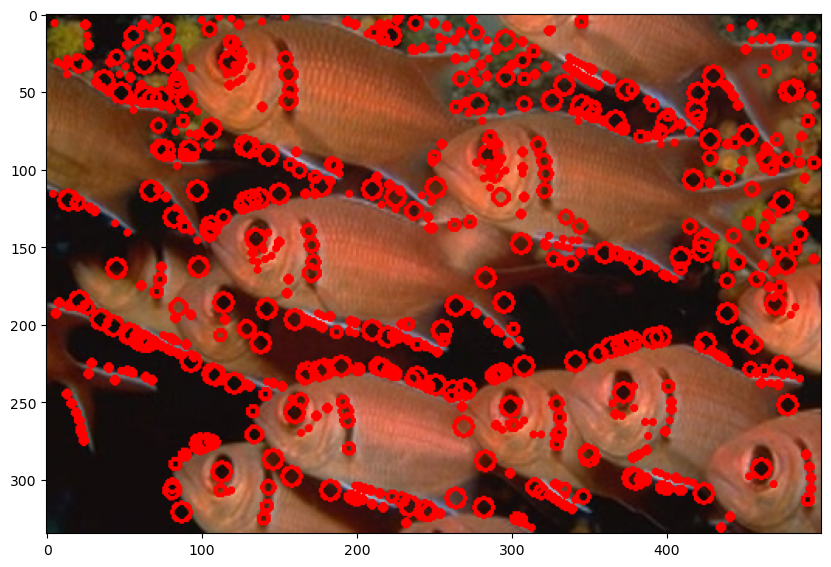

Time taken to complete program =  11.176890134811401 sec


In [1]:
import cv2
import numpy as np
import math
import time
from matplotlib import pyplot as plt

#Generate laplacian of Gaussian filter 
def LoG(level, factor, sigma_init):
    sigma = []  # List to store sigma values
    kernel_sizes = []  # List to store kernel sizes
    LoG = []  # List to store LoG kernels

    for i in range(level):
        # Calculate sigma
        sigma_value = sigma_init * (factor ** i)
        sigma.append(sigma_value)

        # Calculate kernel size rounded to odd
        kernel_size = round(sigma_value * 25)
        if kernel_size % 2 == 0:
            kernel_size += 1
        kernel_sizes.append(kernel_size)

        # Generate tkernel_sizese LoG kernel for tkernel_sizesis sigma
        LoG1 = np.zeros((kernel_size, kernel_size))
        r1 = int(-(math.floor(kernel_size / 2)))
        r2 = int(math.floor(kernel_size / 2))

        for x in range(r1, r2 + 1):
            for y in range(r1, r2 + 1):
                LoG1[x + r2, y + r2] = (-1 / (math.pi * (sigma_value ** 2))) * (
                    1 - ((x ** 2 + y ** 2) / (2 * (sigma_value ** 2)))
                ) * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma_value ** 2))))
        LoG.append(LoG1)

    return sigma, kernel_sizes, LoG

# build a Laplacian Scale Space
def conv2d(image, log, level, kernel_sizes):
    rows, cols = image.shape
    log_output = []

    # Loop through each level 
    for i in range(level):
        # Flip the filter (log kernel) horizontally and vertically
        log[i] = np.flipud(np.fliplr(log[i]))

        # Initialize output image for the current level
        output = np.zeros_like(image)

        # Calculate padding size based on kernel size
        kernel_size = kernel_sizes[i]
        pad_size = kernel_size // 2
        
        # Pad the image borders 
        padded_image = np.pad(image, pad_width=((pad_size, pad_size), (pad_size, pad_size)), mode="constant", constant_values=0)

        # Perform convolution
        for x in range(rows):
            for y in range(cols):
                region = padded_image[x:x + kernel_size, y:y + kernel_size]
                output[x, y] = np.sum(region * log[i])
                output[x, y] = np.clip(output[x, y], 0, 255)
        log_output.append(output)

    return log_output 

#perform 
def nonMaxSup(img, convout, sigma, level, threshold):
    rows = img.shape[0]
    cols = img.shape[1]

    # Prepare a padded version of the convolution output for boundary handling
    padded_conv = np.pad(convout, ((0, 0), (1, 1), (1, 1)), mode="constant", constant_values=-np.inf)

    # Iterate over scales
    for scale_idx in range(level):
        radius = int(math.sqrt(2) * sigma[scale_idx])

        # Get the slice for the current scale
        current_scale = convout[scale_idx]

        # Compare with neighbors in a 3x3x3 window (current scale and adjacent scales)
        max_in_neighbors = np.zeros_like(current_scale)

        for scale_offset in range(-1, 2):
            neighbor_scale_idx = scale_idx + scale_offset
            if 0 <= neighbor_scale_idx < level:
                # Extract a 3x3 neighborhood around each pixel
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]:
                    shifted = padded_conv[neighbor_scale_idx, 1 + dx : 1 + rows + dx, 1 + dy : 1 + cols + dy]
                    max_in_neighbors = np.maximum(max_in_neighbors, shifted)

        # Identify local minima
        minima_mask = (current_scale == max_in_neighbors) & (current_scale > threshold)

        # Check radius-based bounds
        minima_mask[:radius, :] = 0
        minima_mask[-radius:, :] = 0
        minima_mask[:, :radius] = 0
        minima_mask[:, -radius:] = 0

        # Draw circles on detected minima
        for row, col in np.argwhere(minima_mask):
            cv2.circle(img, (col, row), radius, (255, 0, 0), 2)

    return img

def main():
    img_gray = cv2.cvtColor(cv2.imread('fishes.jpg'), cv2.COLOR_BGR2GRAY)/255
    img_color = cv2.cvtColor(cv2.imread('fishes.jpg'), cv2.COLOR_BGR2RGB)

    level = 10
    factor = 1.25
    sigma_init = 1/math.sqrt(2.5)
    threshold = 0.05

    start = time.time()
    sigma, kernel_sizes, log = LoG(level, factor, sigma_init)
    LoG_output = conv2d(img_gray, log, level, kernel_sizes)
    img_blob = nonMaxSup(img_color, LoG_output, sigma, level, threshold)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_blob)
    plt.show()
    print('Time taken to complete program = ', time.time() - start, 'sec')

if __name__ == "__main__":
    main()

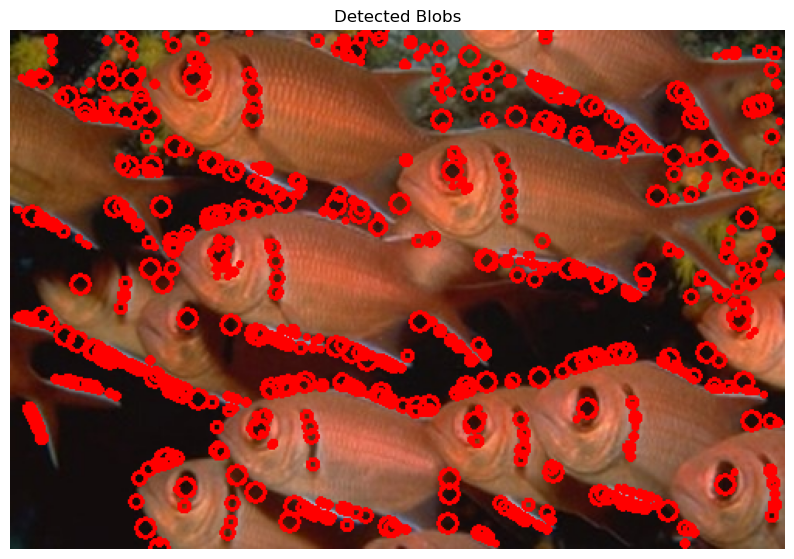

Time taken to complete program =  3.669985055923462 sec


In [13]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

def LoG(level, factor, sigma_init):
    """
    Generate Laplacian of Gaussian (LoG) filters for multiple scales.
    """
    log_kernels = []
    sigma_values = []
    for i in range(level):
        sigma = sigma_init * (factor ** i)
        sigma_values.append(sigma)
        kernel_size = 2 * int(3 * sigma) + 1
        ax = np.arange(-int(kernel_size / 2), int(kernel_size / 2) + 1)
        xx, yy = np.meshgrid(ax, ax)
        norm = (xx**2 + yy**2) / (2 * sigma**2)
        log_kernel = ((xx**2 + yy**2 - 2 * sigma**2) / (sigma**4)) * np.exp(-norm) / (2 * math.pi)
        log_kernels.append(log_kernel)
    return log_kernels, sigma_values

def conv2d(f, w):
    """
    Perform a 2D convolution between an image and a kernel with zero-padding.
    """
    if len(f.shape) == 3:
        h, w_img, c = f.shape
    elif len(f.shape) == 2:
        h, w_img = f.shape
        f = np.expand_dims(f, axis=-1)
        c = 1
    else:
        raise ValueError("Input image must be either grayscale or RGB")
    kernel_h, kernel_w = w.shape
    pad_size = kernel_h // 2
    padded_img = np.pad(f, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)
    output = np.zeros_like(padded_img)
    for channel in range(c):
        for i in range(h):
            for j in range(w_img):
                region = padded_img[i:i + kernel_h, j:j + kernel_w, channel]
                output[i + pad_size, j + pad_size, channel] = np.sum(region * w)
    output_cropped = output[pad_size:h + pad_size, pad_size:w_img + pad_size, :]
    return output_cropped.squeeze() if c == 1 else output_cropped

def build_scale_space(img, log_kernels):
    """
    Build Laplacian scale space.
    """
    scale_space = []
    for kernel in log_kernels:
        response = conv2d(img, kernel)
        scale_space.append(response)
    return scale_space

def nonMaxSup(convout, sigma, level, threshold):
    """
    Perform non-maximum suppression to detect blob centers and return them with their scales.
    """
    rows, cols = convout[0].shape
    blobs = []
    conv_stack = np.stack(convout, axis=0)
    padded_conv = np.pad(conv_stack, ((0, 0), (1, 1), (1, 1)), mode="constant", constant_values=-np.inf)
    for scale_idx in range(level):
        radius = int(math.sqrt(2) * sigma[scale_idx])
        current_scale = convout[scale_idx]
        max_in_neighbors = np.full_like(current_scale, -np.inf)
        for scale_offset in range(-1, 2):
            neighbor_scale_idx = scale_idx + scale_offset
            if 0 <= neighbor_scale_idx < level:
                for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                               (0, -1), (0, 0), (0, 1),
                               (1, -1), (1, 0), (1, 1)]:
                    shifted = padded_conv[neighbor_scale_idx,
                                          1 + dx : 1 + rows + dx,
                                          1 + dy : 1 + cols + dy]
                    max_in_neighbors = np.maximum(max_in_neighbors, shifted)
        maxima_mask = (current_scale == max_in_neighbors) & (current_scale > threshold)
        for row, col in np.argwhere(maxima_mask):
            blobs.append((col, row, radius))
    return blobs

def plot_blobs(img, blobs):
    """
    Plot detected blobs on the image with circles representing their scales.
    """
    for x, y, r in blobs:
        cv2.circle(img, (x, y), r, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Detected Blobs')
    plt.axis('off')
    plt.show()

def main():
    # Load image
    img_color = cv2.imread('fishes.jpg')
    if img_color is None:
        raise FileNotFoundError("Image 'fishes.jpg' not found.")
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY) / 255.0

    # Parameters
    level = 10
    factor = 1.25
    sigma_init = 1 / math.sqrt(2.5)
    threshold = 0.05
    start = time.time()

    # Generate LoG filters
    log_kernels, sigma_values = LoG(level, factor, sigma_init)

    # Build scale space
    scale_space = build_scale_space(img_gray, log_kernels)

    # Perform non-maximum suppression
    blobs = nonMaxSup(scale_space, sigma_values, level, threshold)

    # Plot resulting blobs
    plot_blobs(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB), blobs)
    print('Time taken to complete program = ', time.time() - start, 'sec')

if __name__ == "__main__":
    main()